# Lecture 2: Correcting Errors
### James R. Wootton, IBM Quantum

In the last lecture we looked at how to turn the results from QEC circuits into graphs. This abstraction then allowed us to figure out what errors might have happened for any given output.

But QEC is not just about detecting errors. It's also about correcting them!

In an actual fault-tolerant quantum computation, this correction will be dynamic. Actions we take when implementing logical gates will depend on the errors that we just detected. Nevertheless, we won't always care about the specific details about which errors occurred at which time and place. Instead we'll just need to know larger collective effects of errors, relevant to whatever gate we are applying.

Currently we are only considering memory experiments. There is therefore only one logical operation: final readout of the stored logical information. So when correcting, we need to know the collective effect relevant for this.

## Correcting final readout

In [1]:
from qiskit_qec.decoders import DecodingGraph
from qiskit_qec.circuits import RepetitionCodeCircuit

import numpy as np
from retworkx.visualization import mpl_draw

To be concrete, let's again take the specific example of the repetition code. But this time we'll use something a bit bigger: 5 repetitions and 4 rounds of syndrome measurements.

In [2]:
d,T = 5,7
code = RepetitionCodeCircuit(d,T,resets=True)
dec_graph = DecodingGraph(code)

Here's what the syndrome graph looks like.

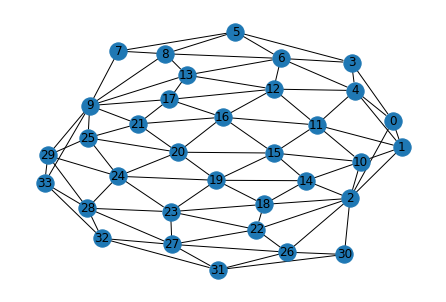

In [3]:
mpl_draw(dec_graph.graph, with_labels=True)

Actually, we can do better than just let `matplotlib` try to figure out how to plot it. Since the nodes contain information about their time and place, we can use these to set positions.

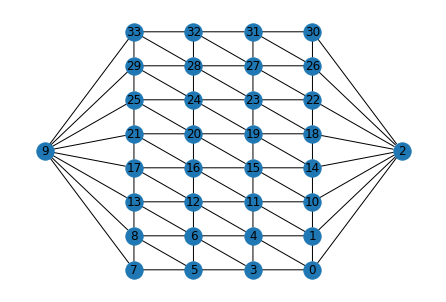

In [4]:
def get_pos(dec_graph):
    pos = []
    for node in dec_graph.graph.nodes():
        if node['is_boundary']:
            if node['qubits'][0]==0:
                pos.append([-1,T/2])
            else:
                pos.append([node['qubits'][0]+1,T/2])
        else:
            pos.append([np.mean(node['qubits']),node['time']])
    return pos
        
pos = get_pos(dec_graph)
mpl_draw(dec_graph.graph, with_labels=True, pos=pos)

Here the horizontal edges correspond to errors on code qubits between syndrome measurement rounds. Vertical ones correspond to those on auxiliary qubits. The diagonal edges (in the bulk) are errors that occur during measurement rounds.

The remaining links are those at the edges, connecting to nodes 2 and 9. Here they are in full.

In [5]:
for n in [9, 2]:
    print('node',n,'is',dec_graph.graph.nodes()[n])

node 9 is {'time': 0, 'qubits': [0], 'is_boundary': True, 'element': 0}
node 2 is {'time': 0, 'qubits': [4], 'is_boundary': True, 'element': 1}


These are the those for the two boundary nodes. They arise whenever one of the edge code qubits is flipped. For example

In [6]:
def print_nodes(nodes):
    for node in nodes:
        print('node',dec_graph.graph.nodes().index(node),'is',node)   

print_nodes(code.string2nodes('10000 0000 0000 0000 0000 0000 0000 0000'))

node 9 is {'time': 0, 'qubits': [0], 'is_boundary': True, 'element': 0}
node 33 is {'time': 7, 'qubits': [0, 1], 'is_boundary': False, 'element': 0}


As we saw in the last lecture, any single error in this code creates two nodes. This edge qubit is involved in only one syndrome measurement, which contribites only one node. So we look at the readout of the code qubit itself. When this is not the value it is supposed to be, it gives us the other node. Since this is an odd one, we flag it up as a boundary node.

The other boundary node comes, of course, from the other boundary.

In [7]:
print_nodes(code.string2nodes('00001 0000 0000 0000 0000 0000 0000 0000'))

node 2 is {'time': 0, 'qubits': [4], 'is_boundary': True, 'element': 1}
node 30 is {'time': 7, 'qubits': [3, 4], 'is_boundary': False, 'element': 3}


Determining whether one of these boundary nodes exists or not means we need to compare the final measured value of these edge qubits with the value they should be. 

To get the right nodes when storing a logical `1`, for example, we need to make sure to inform the `string2nodes` function that we should have a logical `1`. So for the example where the left edge qubit is flipped:

In [8]:
print_nodes(code.string2nodes('01111 0000 0000 0000 0000 0000 0000 0000', logical='1'))

node 9 is {'time': 0, 'qubits': [0], 'is_boundary': True, 'element': 0}
node 33 is {'time': 7, 'qubits': [0, 1], 'is_boundary': False, 'element': 0}


The trouble is, we don't know what value these should output have in general. In the error free case, they will output the logical value, but the logical value is exactly the thing we are measuring. If we need to know its correct value in order to correct a faulty measurement, then there's no point in the fault measurement!

In 'real life' situations, we would therefore want to consider all the boundary nodes that could emerge for different logical values. In `string2nodes` we can obtain this with `all_logicals=True`.

In [9]:
print_nodes(code.string2nodes('10000 0000 0000 0000 0000 0000 0000 0000', all_logicals=True))

node 9 is {'time': 0, 'qubits': [0], 'is_boundary': True, 'element': 0}
node 2 is {'time': 0, 'qubits': [4], 'is_boundary': True, 'element': 1}
node 33 is {'time': 7, 'qubits': [0, 1], 'is_boundary': False, 'element': 0}


In [10]:
error_nodes = code.string2nodes('01111 0000 0000 0000 0000 0000 0000 0000', all_logicals=True)
print_nodes(error_nodes)

node 9 is {'time': 0, 'qubits': [0], 'is_boundary': True, 'element': 0}
node 2 is {'time': 0, 'qubits': [4], 'is_boundary': True, 'element': 1}
node 33 is {'time': 7, 'qubits': [0, 1], 'is_boundary': False, 'element': 0}


Here the case of a flip to the leftmost qubit results in the same three nodes, regardless of logical value. Let's highlight these nodes on the error graph.

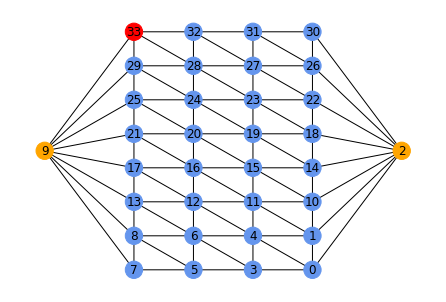

In [11]:
def highlight(error_nodes, dec_graph):
    highlighted_color = []
    for n, node in enumerate(dec_graph.graph.nodes()):
        if node['is_boundary']:
                highlighted_color.append('orange')
        else:
            if node in error_nodes:
                highlighted_color.append('red')
            else:
                highlighted_color.append('cornflowerblue')
    return highlighted_color
        
mpl_draw(dec_graph.graph, with_labels=True, pos=pos, node_color=highlight(error_nodes,dec_graph))

Here the boundary nodes have been highlighted orange, and the bulk node is red.

Our decoding problem is much as it was before. We take the nodes present in our output, and try to pair them up. But here it is only the node in the bulk that *must* be paired with something. The edge nodes only need to get involved when they are required for pairing with the bulk nodes.

In this case, it is pretty clear that our bulk node (33) should be paired with its neighbouring edge node (9). The remaining edge node (2) is not required and can be ignored.

In doing so we have inferred that the error was the one that creates nodes 9 and 33. Above we saw that these arise in two possible cases:

    '10000 0000 0000 0000 0000 0000 0000 0000'
    '01111 0000 0000 0000 0000 0000 0000 0000'
    
In both cases, the error is that the leftmost qubit output the wrong value. So when extracting the logical value, we have two options:

* Look at the result of the leftmost qubit, and use the opposite value as the logical readout;
* Take the raw value of the rightmost qubit (or any other) as the logical readout.

Now let's look at another example.

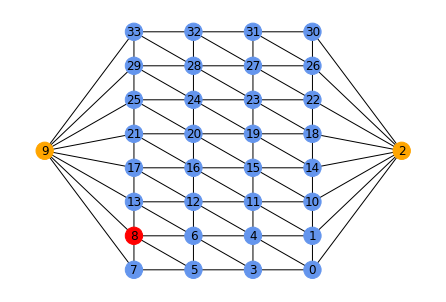

In [12]:
error_nodes = code.string2nodes('01111 1000 1000 1000 1000 1000 1000 0000', all_logicals=True)
mpl_draw(dec_graph.graph, with_labels=True, pos=pos, node_color=highlight(error_nodes,dec_graph))

Now it's node 8 that needs to be dealt with. Again, we can pair it with the boundary node. This implies that there was a flip on the leftmost qubit between the first and second syndrome rounds. So again we conclude that this qubit's final readout cannot be trusted.

But what if we combine the two.

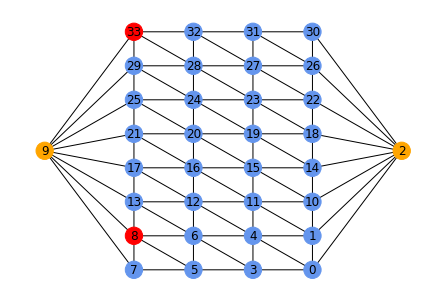

In [13]:
error_nodes = code.string2nodes('11111 1000 1000 1000 1000 1000 1000 0000', all_logicals=True)
mpl_draw(dec_graph.graph, with_labels=True, pos=pos, node_color=highlight(error_nodes,dec_graph))

Here we see both nodes 8 and 33. These aren't neighbours, so we need to find a path of edges that connect them. The shortest path (and hence the one that implies the fewest errors) is the one that goes via node 9. This implies that both of the errors in the previous two examples occurred.

It's important to note that the boundary node is not required for this. So our decoding in this case does not tell us not to trust the readout of the leftmost qubit. Instead it tells us that it can be trusted: we can take its raw value as our logical readout. This is because, though this qubit was flipped, it was also later flipped back to what it should be.

A similar example is as follows.

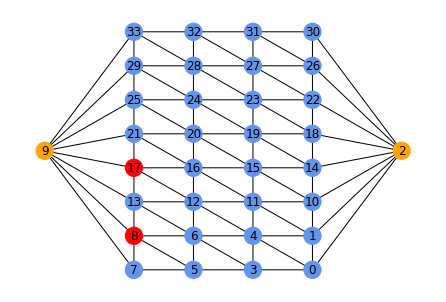

In [14]:
error_nodes = code.string2nodes('11111 0000 0000 0000 0000 1000 1000 0000', all_logicals=True)
mpl_draw(dec_graph.graph, with_labels=True, pos=pos, node_color=highlight(error_nodes,dec_graph))

Here there are two minimal ways to pair nodes 8 and 17:
* via the boundary;
* vertically.

The former implies the same kind of process we just saw: the leftmost qubit is flipped, but then gets flipped back. The latter implies a different pair of errors: faulty results for the leftmost syndrome measurement in the second and third rounds.

So which actually happened? The answer is, that we don't actually care. The life stories of individual qubits are not important. Things are only important if they are important to our logical operation. In this case, that means figuring out how to get a logical readout from the final measurements of the qubits.

Since neither boundary node is involved, and since the boundary nodes are tied explicitly to the trustworthness of the boundary qubits for logical readout, we know that we can take the raw value of either. Regardless of what kind of error happened.

Similarly for the following example.

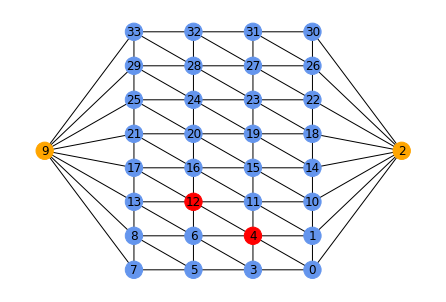

In [15]:
error_nodes = code.string2nodes('11011 0110 0110 0110 0110 0110 0010 0000', all_logicals=True)
mpl_draw(dec_graph.graph, with_labels=True, pos=pos, node_color=highlight(error_nodes,dec_graph))

It looks like the middle code qubit got flipped and a syndrome measurement lied, but exactly where and when is ambigious. And also irrelevant, since neither involves the two qubits that we might choose to consult for final readout.

## Decoding in action

Now we'll take a specific example to see decoding in action. To keep things simple we'll use the `d=9`, `T=0` repetition code. This is actually entirely non-quantum, since it doesn't even involve `cx` gates. It is just the principle of repeating things, and then going with the majority. Nevertheless, the problem of decoding can be dealt with in the same way.

In [16]:
d,T = 9,0
code = RepetitionCodeCircuit(d,T,resets=True)
code.readout()


This will just give the final readout of the code qubits, which will be a repetition of the stored logical value.

In [17]:
from qiskit import Aer
backend_sim = Aer.get_backend('qasm_simulator')

for logical, qc in code.circuit.items():
    job = backend_sim.run(qc)
    counts = job.result().get_counts()
    output = list(counts.keys())[0]
    print('Output for a stored',logical,'is',output)

Output for a stored 0 is 000000000
Output for a stored 1 is 111111111


For this code we get the following decoding graph.

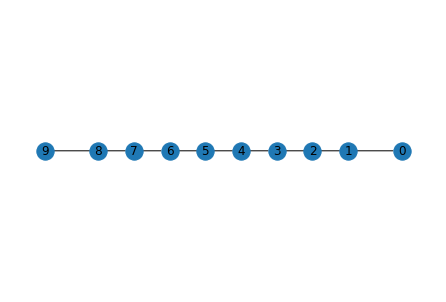

In [18]:
dec_graph = DecodingGraph(code)

pos = get_pos(dec_graph)
mpl_draw(dec_graph.graph, with_labels=True, pos=pos)

To understand it better, let's randomly generate a stored logical bit, and then add in some random bit flip errors.

In [19]:
from random import random, choice

# error probability
p = 0.25

# choose logical value
logical = choice(['0','1'])

# create final readout string, inserting random errors
string = [logical]*d

for j in range(d):
    if random()<p:
        if string[j]=='0':
            string[j] = '1'
        else:
            string[j] = '0'

# compile final string
string = ''.join(string)
print('Output:       ',string)

Output:        101001101


So what was the original encoded logical value that led to the above result? We need to decode.

Given the specific code we have used, we could decode using a boring classical method of seeing which value is in the majority. But that's not compatible with the needs of our quantum codes (as I say in my lecture) so we won't do that.

Of course, we instead use the very graph-based method we've been talking about so far. So let's take a look at the graph.

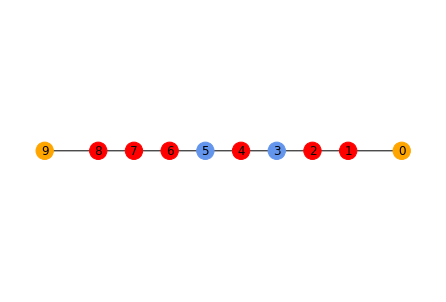

In [20]:
error_nodes = code.string2nodes(string, all_logicals=True)
mpl_draw(dec_graph.graph, with_labels=True, pos=pos, node_color=highlight(error_nodes,dec_graph))

In general we can expect to see obvious pairs of nodes in the bulk, and maybe lonely nodes at the boundaries. In the latter case we can conclude that these need to pair with their nearest boundary. And when they do, it tells us that using the corresponding boundary code qubit for a raw readout will give us the wrong result.

So let's get our raw readout specifically from the left boundary code qubit. Given the graph above, should that boundary be paired? Input your answer in the code block below.

In [21]:
left_boundary_paired = False

Now to get the corrected output. We get the value from the left boundary, and then flip it if the left boundary is paired. This gives our corrected readout of the logical value.

In [22]:
def correct_readout(logical, string,left_boundary_paired):
    print('Encoded logical value:     ',logical)

    logical_readout = string[0]
    print('Raw logical readout:       ',logical_readout)

    if left_boundary_paired:
        logical_readout = str((int(logical_readout)+1)%2)

    print('Corrected logical readout: ',logical_readout)
    if logical_readout==logical:
        print('Correction successful!      :)')
    else:
        print('Correction failed!          :(')

correct_readout(logical, string, left_boundary_paired)

Encoded logical value:      0
Raw logical readout:        1
Corrected logical readout:  1
Correction failed!          :(


Try it a few more times by going back and generating a new output.

## When decoding fails

Suppose we had a stored logical `0`, and the final output came out as `100000000`.

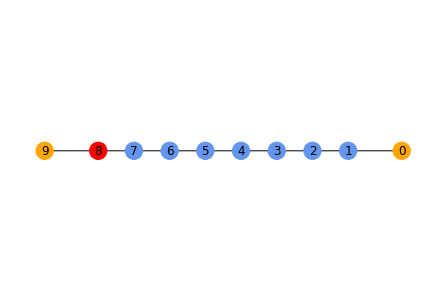

In [23]:
logical = '0'
string = '100000000'
error_nodes = code.string2nodes(string, all_logicals=True)
mpl_draw(dec_graph.graph, with_labels=True, pos=pos, node_color=highlight(error_nodes,dec_graph))

We would not hestitate to delare that the left boundary should be paired, and correct accordingly.

In [24]:
left_boundary_paired = True
correct_readout(logical,string,left_boundary_paired)

Encoded logical value:      0
Raw logical readout:        1
Corrected logical readout:  0
Correction successful!      :)


But what if two qubits were flipped, rather than just one?

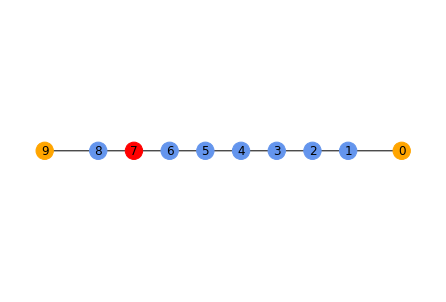

In [25]:
string = '110000000'
error_nodes = code.string2nodes(string, all_logicals=True)
mpl_draw(dec_graph.graph, with_labels=True, pos=pos, node_color=highlight(error_nodes,dec_graph))

It still makes most sense to pair with the left, so all would still be fine. The same would be true even if four errors occurred in a line.

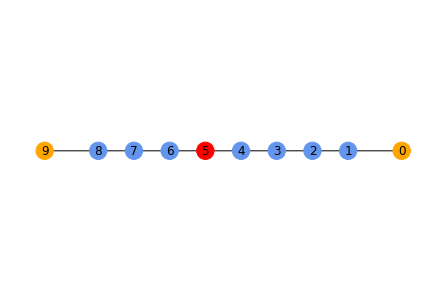

In [26]:
string = '111100000'
error_nodes = code.string2nodes(string, all_logicals=True)
mpl_draw(dec_graph.graph, with_labels=True, pos=pos, node_color=highlight(error_nodes,dec_graph))

We have a single node that can be paired with the left or right boundary. But the left boundary is closer, so we go for that.

But what about five flips?

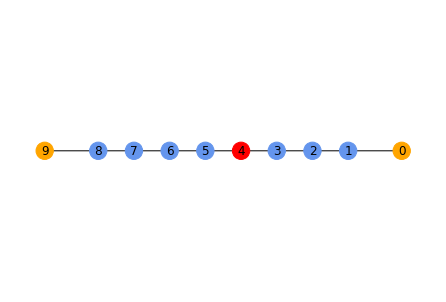

In [27]:
string = '111110000'
error_nodes = code.string2nodes(string, all_logicals=True)
mpl_draw(dec_graph.graph, with_labels=True, pos=pos, node_color=highlight(error_nodes,dec_graph))

This situation can be explained by there being five flips on the left side of the code, or four flips on the right. If all flips are equally likely, its more probably that the four flips on the left occurred. So we pair node 4 with the right boundary.

In [28]:
left_boundary_paired = False

And decode accordingly.

In [29]:
correct_readout(logical, string,left_boundary_paired)

Encoded logical value:      0
Raw logical readout:        1
Corrected logical readout:  1
Correction failed!          :(


Our 'corrected' readout is therefore incorrect!

A similar thing would happen for five flips on the right side of the code.

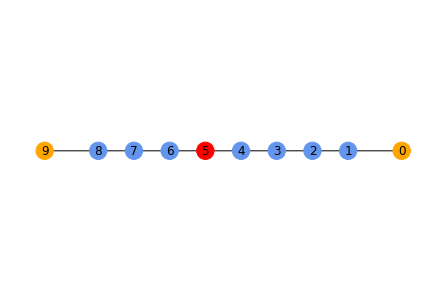

In [30]:
string = '000011111'
error_nodes = code.string2nodes(string, all_logicals=True)
mpl_draw(dec_graph.graph, with_labels=True, pos=pos, node_color=highlight(error_nodes,dec_graph))

In this case we conclude that the leftmost boundary *should* be paired.

In [31]:
left_boundary_paired = True

We therefore don't trust our raw logical readout, even though it is correct.

In [32]:
correct_readout(logical,string,left_boundary_paired)

Encoded logical value:      0
Raw logical readout:        0
Corrected logical readout:  1
Correction failed!          :(


In fact, any set of 5 or more errors will cause the decoding to fail.

This is because the repetition code is built on the idea that repeating a value makes it easier to protect. For $d$ repetitions, you'd need to flip at least half in order for the correct value to no longer have the majority. For $d=9$ that means flipping more that 4.5, and hence 5 or more.

We can protect against these failures by increasing the size of our code. The number of errors required to fool the decoder will therefore increase. But there's no way to fully protect against the fact that sometimes, our attempts at correction will actually serve to consolidate very large errors.

## Now let's decode!

Decoding is a bit like a puzzle game. So let's play it as a game!

Specifically, we'll use a new implementation of my *Decodoku* citizen science project from 2016 (see the blog [here](http://decodoku.blogspot.com/2016/03/quantum-error-correction-game.html).

For the version we'll be using, we'll need the game engine hidden in the Qiskit textbook. You can install this (and the other tools from the textbook)  the following command.

In [33]:
#!pip install git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src
#!pip install distinctipy

Once that's installed we can import the game.

In [34]:
from decodoku import Decodoku

The game is played on a fairly abstract decoding graph, defined by a size `L`. You can think of it as a `d=L-1`, `T=L+1` repetition code, or an $L\times(L+1)$ surface code with `T=0`. But we don't really have to think about what code is behind it: we have a decoding graph, so our job is to get decoding!

We'll start with one for `L=10` and an error probability `p=0.1`.

In [35]:
game = Decodoku(L=10, p=0.1)

The decoding graph object on which the game is based can be accessed using `game.decoding_graph`. There's also a method that plots is nicely for us, so let's take a look.

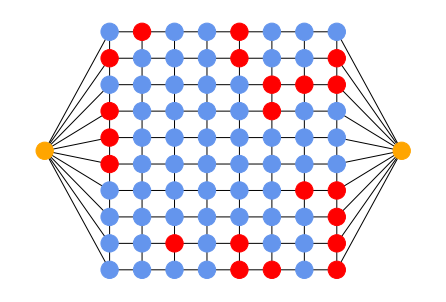

In [36]:
game.draw_graph()

The boundary nodes represent some collective property of the errors that is relevant for our logical operator. For the repetition code memory experiments dicussed above, this would be whether or not the logical output needs to be corrected. But we can keep things abstract here. They are just some logical thing, and we need to know the correction to apply.

Because this is a game, we know what the correct answer is. You can cheat by looking it up as follows. The list shows the correction that needs to be applied to the left and right boundaries, respectively.

In [37]:
game.boundary_errors

[1, 0]

But we need to work it out for ourselves. You can actually interact with the problem using the following cell.

The idea is that you are going to clean up the syndrome. You do this by moving highlighted nodes together. We think of this as identifying that there was some common set of errors that created them. By moving them together, we get what the syndrome would have been if that error was corrected. Since errors create highlighted nodes in pairs, moving a pair together 'annihilates' them.

If you think a highlighted node belongs with a boundary, then move it to that boundary. The total effect of all these interactions with the boundary determine the final correction for the decoding you've done.

**How to move nodes**
* Choose a red square to move by clicking on it.
* To move it, choose the new location by clicking on it.
* To cancel your selection, press 'Next'.
* Note: When moving to a boundary, it doesn't matter where in the boundary you move it to.

**How the game ends**
* The game ends when all highlighted nodes have been removed.
* The `boundary_errors` that needed to be corrected are shown at the top of each boundary.
* The `boundary_corrections` calculated by your solution are shown at the bottom.
* Press 'Next' to start another game.


In [38]:
game.run()

Of course, for actual fault-tolerant quantum computation we aren't really going to do this manually. We want to define algorithms to do it for us.

Below is an example of such a decoder. It splits the highlighted nodes into a set of clusters. Each cluster should contain either an even number of nodes (so that they can be multually annihilated) or should contain a boundary (so that any spare nodes can be paired with that). By looking at the clusters that contain the boundaries, we can see what correction is suggusted by the decoder.

Specifically, it is a very simple and pretty bad decoder. It splits everything into only two clusters: one for each boundary. It assumes that every highlighted node on the right side of the code should be used to determine the correction for the right, and all on the left should be used for the correction on the left.

In [39]:
def process(game):
    
    L = game.L
    decoding_graph = game.decoding_graph
    nodes = decoding_graph.graph.nodes()

    # we'll split nodes into two clusters
    clusters = {}
    # cluster 0 is defined the one containing the left boundary, and cluster 1 is the one with the right
    for n, node in enumerate(nodes):
        if node['is_boundary']:
            clusters[n] = node['element']

    # we now divide the highlighted nodes into these two, depending on which edge they are closest to
    for n, node in enumerate(nodes):
        if node['highlighted']:
            if node['element']<(L-2)/2:
                clusters[n] = 0
            else:
                clusters[n] = 1

    # the parity of the number of nodes in each cluster determines the correction
    parity = [0,0]
    for n in clusters:
        node = nodes[n]
        if not node['is_boundary']:
            parity[clusters[n]] = (parity[clusters[n]]+1)%2
    boundary_corrections = parity
            
    return boundary_corrections, clusters

When we write an function in this form (with this input and these outputs), we can include it in the initialization of a puzzle.

In [40]:
game = Decodoku(L=10, p=0.1, process=process)

Then if we draw the graph, it will show the clusters that the nodes have been separated into. It also shows the `boundary_correction` output by the decoder.

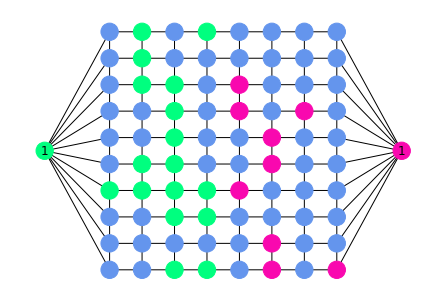

In [41]:
game.draw_graph()

We can then use this as a guide when playing the game.

In [42]:
game.run()

Of course, it's not a very good guide because it's not a good decoder. Note that if we redraw the graph after making some moves, it will rerun the decoder for the new syndrome. We can use this to probe the behaviour of the decoder.

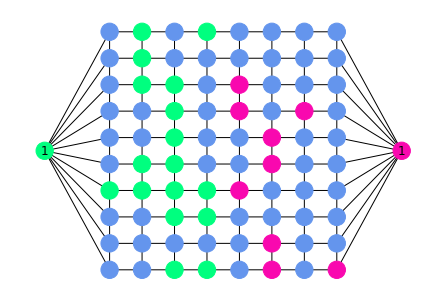

In [43]:
game.draw_graph()

This is the specific decoding problem that we'll be considering for the next few lectures.